<a href="https://colab.research.google.com/github/DiwakarBasnet/nmt_new_eng/blob/main/nmt_new_eng_m2m100_418.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook setup

In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW

# from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import M2M100Tokenizer, AutoModelForSeq2SeqLM

from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
# model_repo = 'google/mt5-small'
model_repo = 'facebook/m2m100_418M'

max_seq_len = 20  # model.config.max_length

## Steps:
1. Load pretrained model and tokenizer
2. Load the dataset
3. Transform the dataset into input
4. Train/finetune the model on our dataset
5. Test the model

## Load pretrained model and tokenizer

In [ ]:
# Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_repo)
tokenizer = M2M100Tokenizer.from_pretrained(model_repo)

In [ ]:
# Custom tokenizer test
# from transformers import RobertaTokenizerFast
# tokenizer = RobertaTokenizerFast.from_pretrained('newabert')

In [ ]:
# Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [ ]:
# Testing pretrained model and tokenizer

input_sen = '<new>This is a test sentence!'
# input_sen = '<en>जि ब्वनेकुथिं लिहां वयाः वसः हिलाबुला याये|'

tokenizer.src_lang = "ne"
token_ids = tokenizer.encode(input_sen, return_tensors='pt').cuda()  # Tokenization
print(tokenizer.convert_ids_to_tokens(token_ids[0]))

model_out = model.generate(token_ids, forced_bos_token_id=tokenizer.get_lang_id("ne"))  # Token input in model
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0])
)
print(output_text)

['__ne__', '▁<', 'new', '>', 'This', '▁is', '▁a', '▁test', '▁sent', 'ence', '!', '</s>']


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     2, 128066,   5966,  68674,   3473,  55086,    117,   1618,  63447,
          23441,   5819,  41334,     30,      2]], device='cuda:0')
</s>__ne__<new>This is एक परीक्षण वाचन!</s>


## Load the dataset

In [ ]:
dataset = load_dataset("Unspoiled-Egg/new-eng-translation")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2502 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Unspoiled-Egg___parquet/Unspoiled-Egg--new-eng-translation-a3d0218a35a0611d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2502
    })
})

In [ ]:
split_datasets = dataset['train'].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2251
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 251
    })
})

In [ ]:
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

In [ ]:
train_dataset['translation'][0]

{'en': 'we must not imitate bad things of others.',
 'new': 'जि व जिगु धायेगु स्वया: झी व झीगु धइगु बिचा: वयेके मा:।'}

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'new': '<new>',
    # 'ne': '<ne>'
}

In [ ]:
# Adding special tokens to tokenizer vocab
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(128106, 1024)

## Transform the dataset into input

In [ ]:
# Our input gets truncated to size 20
token_ids = tokenizer.encode(
    input_sen, return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len
)
print(token_ids)

tensor([[128066, 128105,  36606,    117,      8,   4183,   8931,   6226,     30,
              2,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1]])


In [ ]:
# Function to tokenize input and output

def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]
  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )

  return input_ids[0]


def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )

  return token_ids[0]


def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 for in  i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translation for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None
  
  # Encode our texts to their tokenzied patterns
  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map
  )
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map
  )

  return input_token_ids, target_token_ids


# Convert tokens to batch
def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len
    )
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
  
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids


# Generator function
def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Checking above function (format_translation_data)
in_ids, out_ids = format_translation_data(
    train_dataset[1]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:',data_batch[0].shape)
print('Output shape:',data_batch[1].shape)

__ne__ <en> ▁अन या ▁मन ूत य ् ▁बु ँ ▁ज्या ▁या इ गु । </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
__ne__ ▁people ▁of ▁this ▁place ▁work ▁in ▁field s . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

## Train/finetune the model on our data

In [ ]:
# Parameters
n_epochs = 7
batch_size = 16
print_freq = 50
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
# Evaluation model
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break
    
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch
    )
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
# Training and testing
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  
  # Loop through our batch data
  for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()
    
    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch
    )

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()

    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]
      ))
    
  test_loss = eval_model(model, test_dataset) 
  print('Test loss of {:.3f}'.format(test_loss))

<ipython-input-21-f4b540d517f1>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg loss: 4.325 | lr: 0.000479038854805726
Epoch: 1 | Step: 100 | Avg loss: 2.898 | lr: 0.0004534764826175869
Test loss of 2.949


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg loss: 2.343 | lr: 0.00040695296523517383
Epoch: 2 | Step: 100 | Avg loss: 2.257 | lr: 0.00038139059304703477
Test loss of 2.333


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg loss: 1.788 | lr: 0.0003348670756646217
Epoch: 3 | Step: 100 | Avg loss: 1.910 | lr: 0.0003093047034764827
Test loss of 2.084


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg loss: 1.460 | lr: 0.00026278118609406953
Epoch: 4 | Step: 100 | Avg loss: 1.486 | lr: 0.00023721881390593048
Test loss of 2.243


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg loss: 1.090 | lr: 0.00019069529652351739
Epoch: 5 | Step: 100 | Avg loss: 1.069 | lr: 0.00016513292433537833
Test loss of 2.069


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg loss: 0.708 | lr: 0.00011860940695296524
Epoch: 6 | Step: 100 | Avg loss: 0.759 | lr: 9.304703476482618e-05
Test loss of 2.017


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg loss: 0.460 | lr: 4.652351738241309e-05
Epoch: 7 | Step: 100 | Avg loss: 0.456 | lr: 2.0961145194274028e-05
Test loss of 2.053


## Test model

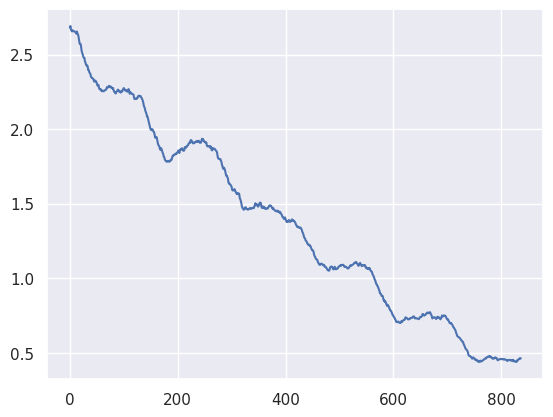

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

### Manual testing

In [ ]:
test_sentence = test_dataset[0]['translation']['new']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'en',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING
)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])
))

Raw input text: मतिना व वया ककां द्य:याथाय् गुकथं द्य: अनियात?
Truncated input text: __ne__<en>मतिना व वया ककां द्य:याथाय् गुकथं द्य: अनियात?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

__ne__ why is matina and her brother?
__ne__ how is matina and her brother?
__ne__ how is matina and her parents?


In [ ]:
test_dataset['translation'][0]

{'en': 'how did matina and her uncle worship in the temple ?',
 'new': 'मतिना व वया ककां द्य:याथाय् गुकथं द्य: अनियात?'}

In [ ]:
train_dataset['translation'][0]

{'en': 'we must not imitate bad things of others.',
 'new': 'जि व जिगु धायेगु स्वया: झी व झीगु धइगु बिचा: वयेके मा:।'}

### Colab form

In [ ]:
#@title Translation cell
input_text = "we must not imitate bad things of others." #@param {type:"string"}
output_language = "new" #@param ["new", "en"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING
)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + ' -> ' + \
        tokenizer.decode(output_tokens[0], skip_special_tokens=True))

we must not imitate bad things of others. -> __ne__ जि व जिगु धायेगु स्वया: झी व झीगु धइ
